<a href="https://colab.research.google.com/github/Szuyingpan/NLP-Project-LSTM/blob/main/NLP_Sentiment_Analysis_LSTM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing for Sentiment Analysis by using Amazon reviews dataset

## Project Overview:

Sentiment analysis (SA) is a powerful tool for businesses and researchers to understand customer behaviors and opinions at scale. Studies related to NLP techniques for SA in customer reviews often utilize the widely used Amazon reviews dataset. This dataset, receiving a large volume of reviews daily, provides rich insights into customer experiences, satisfaction, and opinion mining about products. Utilizing this dataset allows for practical experience in applying NLP techniques.

This project aims to apply SA techniques to categorize reviews into positive and negative categories, focusing on negative reviews to improve customer experiences. For this purpose, we used the Amazon dataset from Kaggle, which has been split into two datasets: training and testing. The training set contains 3,600,000 reviews, and the test set contains 400,000 reviews. Each dataset has been labeled with two categories, 1 and 2, where 1 indicates negative and 2 indicates positive. We will be performing the following steps to train and test our model using LSTM. In a separate file (NLP_Sentiment Analysis_RoBERTa_Final), we will apply the Twitter-based RoBERTa transformers to compare the performances of these two models.

1. Data collection
2. Importing the data
3. Exploratory the data
4. Data Cleaning
5. Model Building
6. Train the model
7. Predict the result
8. Conclusion
9. Reference

## 1. Data Collection

The dataset was zip file and can be downloaded from :(https://www.kaggle.com/datasets/bittlingmayer/amazonreviews)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import bz2
import zipfile
import os
import re
import random

# NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from tqdm import tqdm
from tqdm.auto import tqdm

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Metric Libraries
from sklearn.feature_extraction.text import CountVectorizer

# ML
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


## 2. Import dataset

In [ ]:
# Initialize lists to store the separated labels and reviews
label = []
review = []

# Open the file and read line by line
with open('/content/drive/MyDrive/Colab Notebooks/train.ft.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Extract sentiment and phrase using regex
        match = re.match(r'(__label__\d) (.*)', line)
        if match:
            label.append(match.group(1).replace('__label__1', '0').replace('__label__2', '1'))
            review.append(match.group(2))

# Create a DataFrame from the lists
data = pd.DataFrame({
    'label': label,
    'review': review
})

In [ ]:
# Extract 10% of the total train data and ensure they are equal

# Separate the dataframe into two based on the label
data_0 = data[data['label'] == '0']
data_1 = data[data['label'] == '1']

# Calculate the number of samples to extract from each label to get 10% of the total data
samples_per_label = int(0.1 * len(data) / 2)

# Randomly sample from each label
data_0_sample = data_0.sample(n=samples_per_label, random_state=42)
data_1_sample = data_1.sample(n=samples_per_label, random_state=42)

# Concatenate the samples back to form the dataset
train = pd.concat([data_0_sample, data_1_sample])

# Shuffle the dataset
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the first few rows to ensure it's loaded correctly
print(train.head())

  label                                             review
0     0  Not very good: The GPS works great. The softwa...
1     0  it miss the best song: The CD comes with almos...
2     1  Inspiring author: Great book for any water col...
3     1  Elvis on Tour (Blue Ray Book): Wasn't sure if ...
4     1  alternative music review: This is a very good ...


In [ ]:
train.shape

(360000, 2)

In [ ]:
train.head()

,label,review
0,0,Not very good: The GPS works great. The softwa...
1,0,it miss the best song: The CD comes with almos...
2,1,Inspiring author: Great book for any water col...
3,1,Elvis on Tour (Blue Ray Book): Wasn't sure if ...
4,1,alternative music review: This is a very good ...


In [ ]:
# Now two labels amounts are equal
trainvalueCounts = train["label"].value_counts().sort_index()
print(trainvalueCounts)

0    180000
1    180000
Name: label, dtype: int64


In [ ]:
# Initialize lists to store the separated labels and reviews
label = []
review = []

# Open the file and read line by line
with open('/content/drive/MyDrive/Colab Notebooks/test.ft.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Extract sentiment and phrase using regex
        match = re.match(r'(__label__\d) (.*)', line)
        if match:
            label.append(match.group(1).replace('__label__1', '0').replace('__label__2', '1'))
            review.append(match.group(2))

# Create a DataFrame from the lists
data = pd.DataFrame({
    'label': label,
    'review': review
})

In [ ]:
# Extract 10% of the total train data and ensure they are equal

# Separate the dataframe into two based on the label
data_0 = data[data['label'] == '0']
data_1 = data[data['label'] == '1']

# Calculate the number of samples to extract from each label to get 10% of the total data
samples_per_label = int(0.1 * len(data) / 2)

# Randomly sample from each label
data_0_sample = data_0.sample(n=samples_per_label, random_state=42)
data_1_sample = data_1.sample(n=samples_per_label, random_state=42)

# Concatenate the samples back to form the dataset
test = pd.concat([data_0_sample, data_1_sample])

# Shuffle the dataset
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the first few rows to ensure it's loaded correctly
print(test.head())

  label                                             review
0     1  Maxim Delivers: The subscription delivers exac...
1     0  TOXIC TO CATS: When Googling this product as a...
2     1  * LOVE IT * LUVIT * LOVIT * LUV IT *: All I ca...
3     0  I Almost Gave It a 5 Star Review: I would have...
4     1  I love this album: I've never reviewed music b...


In [ ]:
test.shape

(40000, 2)

In [ ]:
# Now two labels amounts are equal
valueCounts = test["label"].value_counts().sort_index()
print(valueCounts)

0    20000
1    20000
Name: label, dtype: int64


In [ ]:
count_good = train[train['label'] == '1']

In [ ]:
count_good

,label,review
2,1,Inspiring author: Great book for any water col...
3,1,Elvis on Tour (Blue Ray Book): Wasn't sure if ...
4,1,alternative music review: This is a very good ...
8,1,3M Ergonomic Mouse: Good product for the money...
9,1,One of the best: Hi! Though i'm french and i l...
...,...,...
359985,1,Better than most give it credit for...: While ...
359987,1,Best prepaid deal out there: This seems to be ...
359988,1,Excellent music but a strange choice to releas...
359993,1,INSPIRATION FLOWS!: Tuesday's with morrie was ...


In [ ]:
# Remove duplicate rows
train = train.drop_duplicates()
train.shape

(360000, 2)

There is no duplicate rows

In [ ]:
print(train.isna().sum())

label     0
review    0
dtype: int64


There is no missing values.

## 3. Exploratory Data Analysis

In [ ]:
%matplotlib inline

# Count of good and bad reviews
count = train['label'].value_counts()

# Creating a function to plot the counts using matplotlib
def plot_counts(count_good, count_bad):
    plt.rcParams['figure.figsize'] = (6, 6)
    plt.bar(1, count_good, width=0.6, label='Positive Reviews', color='Green')
    plt.bar(0, count_bad, width=0.6, label='Negative Reviews', color='Red')
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
    plt.legend()
    plt.show()

# Extract counts of good and bad reviews
count_good = train[train['label'] == '1'].shape[0]
count_bad = train[train['label'] == '0'].shape[0]

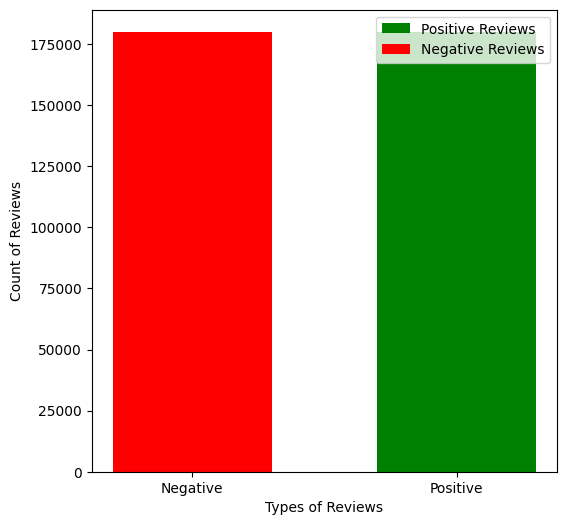

In [ ]:
# Plotting the counts
plot_counts(count_good, count_bad)

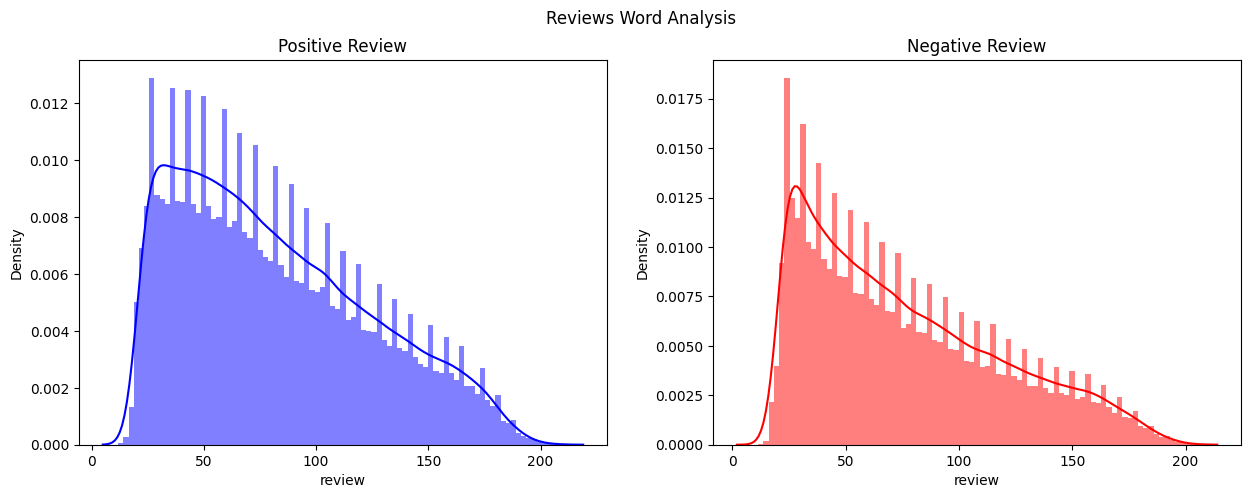

In [ ]:
# Extract the text of positive and negative reviews
good_reviews = train[train['label'] == '1']['review']
bad_reviews = train[train['label'] == '0']['review']

# Define a function to calculate the length of data
def cal_len(data):
    return len(data)

# Create a generic plotter with Seaborn
def plot_count(count_ones, count_zeros, title_1, title_2, subtitle):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(count_zeros, ax=ax1, color='Blue', kde=True, stat="density", linewidth=0)
    ax1.set_title(title_1)
    sns.histplot(count_ones, ax=ax2, color='Red', kde=True, stat="density", linewidth=0)
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()

# Calculate word counts for positive and negative reviews
count_good_words = good_reviews.str.split().apply(lambda z: cal_len(z))
count_bad_words = bad_reviews.str.split().apply(lambda z: cal_len(z))

# Plotting the counts
plot_count(count_good_words, count_bad_words, "Positive Review", "Negative Review", "Reviews Word Analysis")

Both plots display the kernel density estimation; this visualization aids in comparing the lengths of reviews based on their labels. On the left, the lengths of positive reviews range from 25 to 75 words. On the right, the lengths of negative reviews range from 20 to 40 words. Clearly, negative reviews are shorter than positive ones.

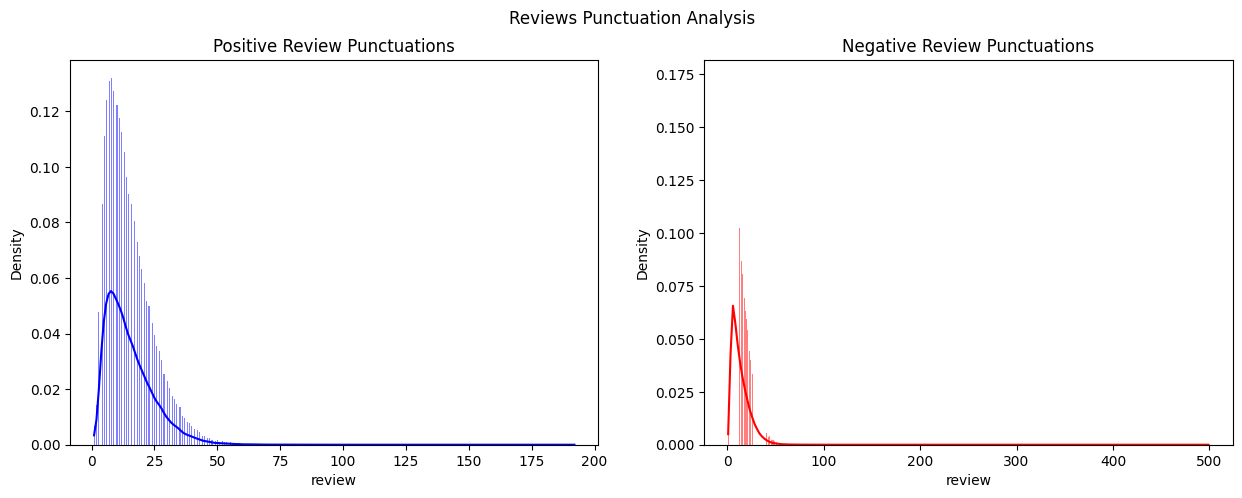

In [ ]:
# Let's take a look at punctation
count_good_punctuations = good_reviews.apply(lambda z: len([c for c in str(z) if c in string.punctuation]))
count_bad_punctuations = bad_reviews.apply(lambda z: len([c for c in str(z) if c in string.punctuation]))

# Plotting the counts of punctuations
plot_count(count_good_punctuations, count_bad_punctuations, "Positive Review Punctuations", "Negative Review Punctuations", "Reviews Punctuation Analysis")


On the left, we observe the distribution of punctuation counts in positive reviews (in blue), and on the right, the distribution for negative reviews (in red), with both plots including kernel density estimates for a clearer view of density across various counts. We can see that positive reviews shows a higher density than negative reviews.

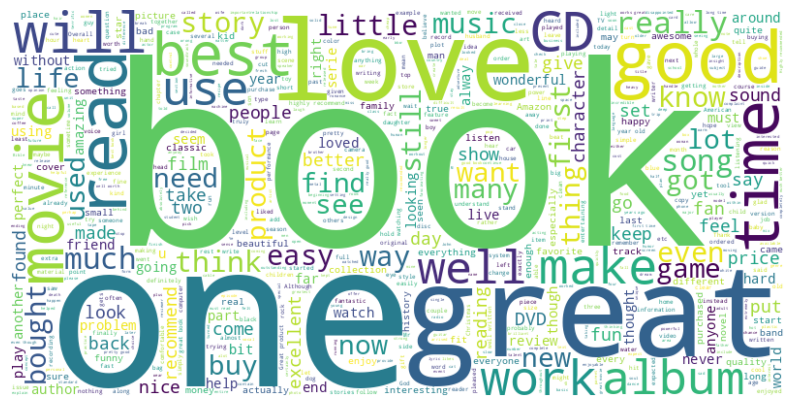

In [ ]:
def display_simple_cloud(data, color='black', max_words=20000):
    plt.figure(figsize=(10,10))
    wc = WordCloud(stopwords=STOPWORDS,
                   background_color="white",
                   contour_width=2,
                   contour_color=color,
                   max_words=max_words,  # Reduced number of words
                   width=800,            # Standard width
                   height=400)           # Standard height
    wc.generate(' '.join(data[:20000]))  # Generate from the first 20000 reviews (as an example)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

display_simple_cloud(good_reviews.tolist(), 'red')  # Convert DataFrame column to list

Positive words such as "great," "good," "love," "well," "want," "excellent," "best," and "easy" are shown in the cloud. Words like "book," "album," "movie," "music," "read," "story," "DVD," and "CD" can give us a clue that the reviews are mostly related to those products.

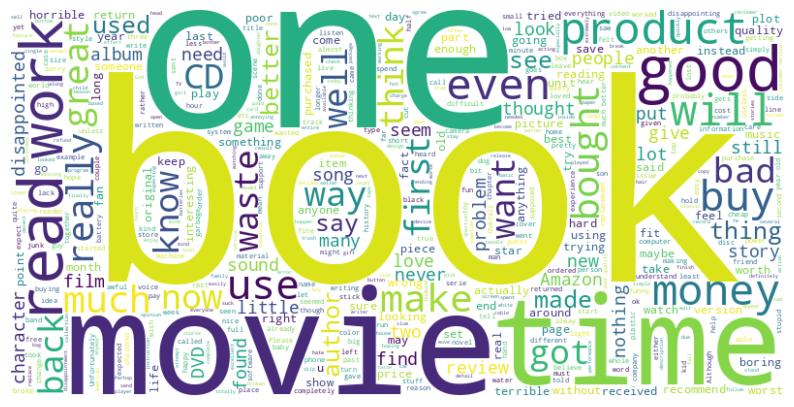

In [ ]:
display_simple_cloud(bad_reviews.tolist(), 'blue')

Negative words such as "disappointed," "waste," "horrible," and "bad" appear frequently. Words like "book," "movie," and "time" may relate to the product. Interestingly, we also found positive words like "good," "well," "want," and "better" in the negative word cloud. This suggests that we should consider the context of the words, rather than focusing on the words alone.

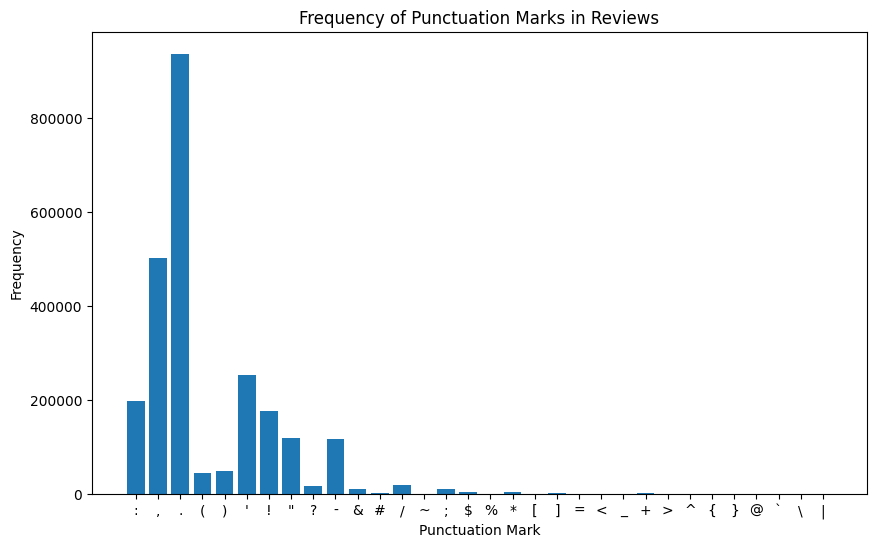

In [ ]:
# Removing punctuation? visualise good reviews

from collections import Counter

# Rreviews is a list of review texts
reviews = good_reviews

# Combine all reviews into one large string
all_reviews = " ".join(reviews)

# Count all punctuation marks in the reviews
punctuation_counts = Counter(c for c in all_reviews if c in string.punctuation)

# Visualize the counts
plt.figure(figsize=(10, 6))
plt.bar(punctuation_counts.keys(), punctuation_counts.values())
plt.title('Frequency of Punctuation Marks in Reviews')
plt.xlabel('Punctuation Mark')
plt.ylabel('Frequency')
plt.show()

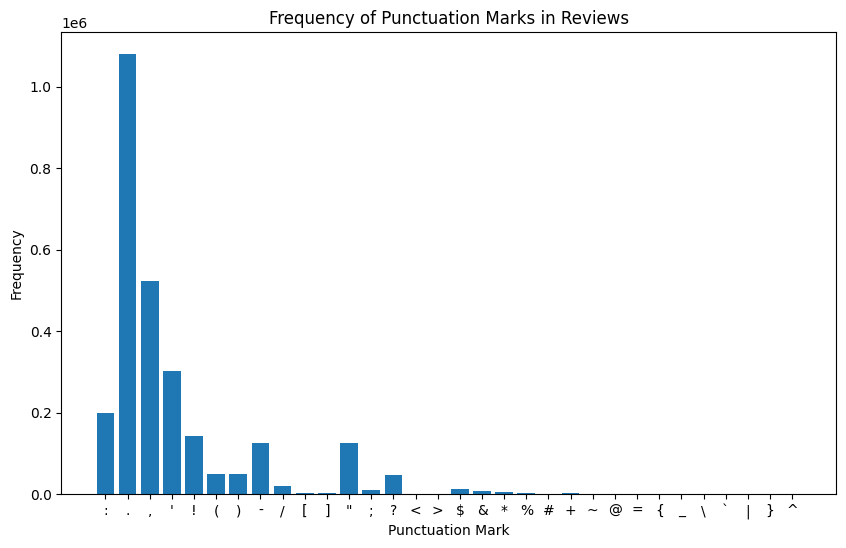

In [ ]:
# Visualise bad reviews

# Rreviews is a list of review texts
reviews = bad_reviews

# Combine all reviews into one large string
all_reviews = " ".join(reviews)

# Count all punctuation marks in the reviews
punctuation_counts = Counter(c for c in all_reviews if c in string.punctuation)

# Visualize the counts
plt.figure(figsize=(10, 6))
plt.bar(punctuation_counts.keys(), punctuation_counts.values())
plt.title('Frequency of Punctuation Marks in Reviews')
plt.xlabel('Punctuation Mark')
plt.ylabel('Frequency')
plt.show()

From above both graphes, we can see that punctuation marks with emotional connotations, such as "!" and "?", occur less frequently in the text. Instead, " . ", " , " and " ' " are more higher than others. In this case, we will remove them in the next step.

## 4. Data Cleaning

In [ ]:
download: nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
# download wordnet library which is a lexical database for English word
nltk.download('wordnet')
nltk.download('stopwords') # stopwords has been predefined
nltk.download('punkt')# tokenizer

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk import tokenize

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#!pip install inflect
import inflect
p = inflect.engine()
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim

In [ ]:
# Define the text-preprocessing function

%%time

# Removes Punctuations
def remove_punctuations(text):
    punct_tag = re.compile(r'[^\w\s]')
    text = punct_tag.sub(r'', text)
    return text

# Removes HTML syntaxes
def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    text = html_tag.sub(r'', text)
    return text

# Removes URL data
def remove_url(text):
    url_clean = re.compile(r"https://\S+|www\.\S+")
    text = url_clean.sub(r'', text)
    return text

# Removes Emojis
def remove_emoji(text):
    emoji_clean = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    return text

# Convert text to lowercase
def to_lowercase(text):
    return text.lower()

# Removes extra spaces
def remove_space(text):
    return text.strip()


# Applying all functions to the 'review' column
train['review'] = train['review'].apply(lambda z: remove_punctuations(z))
train['review'] = train['review'].apply(lambda z: remove_html(z))
train['review'] = train['review'].apply(lambda z: remove_url(z))
train['review'] = train['review'].apply(lambda z: remove_emoji(z))
train['review'] = train['review'].apply(lambda z: to_lowercase(z))
train['review'] = train['review'].apply(lambda z: remove_space(z))

CPU times: user 10.6 s, sys: 18.2 ms, total: 10.6 s
Wall time: 10.6 s


In [ ]:
# Define a function for a single review
def clean_and_lemmatize_review(review):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Remove stop words
    tokens = [word for word in word_tokenize(review) if not word in stop_words]

    # Apply lemmatizer
    lem_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(lem_tokens)

# text to clean and lemmatize
train['review'] = train['review'].apply(clean_and_lemmatize_review)

In [ ]:
# Calculate the length of each review in terms of number of words
review_lengths = train['review'].apply(lambda x: len(x.split()))

# Now, you can calculate percentiles for these lengths
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for ele in percentiles:
    print('{}th percentile of review lengths is {}'.format(ele, np.percentile(review_lengths, ele)))

10th percentile of review lengths is 15.0
20th percentile of review lengths is 20.0
30th percentile of review lengths is 25.0
40th percentile of review lengths is 30.0
50th percentile of review lengths is 36.0
60th percentile of review lengths is 43.0
70th percentile of review lengths is 51.0
80th percentile of review lengths is 61.0
90th percentile of review lengths is 75.0
100th percentile of review lengths is 184.0


## Preprocessing train reviews

In [ ]:
print(train.head(10))

  label                                             review
0     0  good gps work great software difficult use voi...
1     0  miss best song cd come almost song best song g...
2     1  inspiring author great book water colorist med...
3     1  elvis tour blue ray book wasnt sure wanting ar...
4     1  alternative music review good alternative rock...
5     0  microphone doesnt pick sound headset horrible ...
6     0  something borrowed really surprised book good ...
7     0  new version horrible remember fun old version ...
8     1  3m ergonomic mouse good product money easy use...
9     1  one best hi though im french live france dont ...


## Clean Test Set

In [ ]:
# Calculate the length of each review in terms of number of words
review_lengths = test['review'].apply(lambda x: len(x.split()))

# Now, you can calculate percentiles for these lengths
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for ele in percentiles:
    print('{}th percentile of review lengths is {}'.format(ele, np.percentile(review_lengths, ele)))

10th percentile of review lengths is 28.0
20th percentile of review lengths is 38.0
30th percentile of review lengths is 48.0
40th percentile of review lengths is 58.0
50th percentile of review lengths is 70.0
60th percentile of review lengths is 83.0
70th percentile of review lengths is 99.0
80th percentile of review lengths is 118.0
90th percentile of review lengths is 144.0
100th percentile of review lengths is 209.0


In [ ]:
%%time

# Removes Punctuations
def remove_punctuations(text):
    punct_tag = re.compile(r'[^\w\s]')
    text = punct_tag.sub(r'', text)
    return text

# Removes HTML syntaxes
def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    text = html_tag.sub(r'', text)
    return text

# Removes URL data
def remove_url(text):
    url_clean = re.compile(r"https://\S+|www\.\S+")
    text = url_clean.sub(r'', text)
    return text

# Removes Emojis
def remove_emoji(text):
    emoji_clean = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)
    return text

# Convert text to lowercase
def to_lowercase(text):
    return text.lower()

# Removes extra spaces
def remove_space(text):
    return text.strip()

# Applying all functions to the 'review' column
test['review'] = test['review'].apply(lambda z: remove_punctuations(z))
test['review'] = test['review'].apply(lambda z: remove_html(z))
test['review'] = test['review'].apply(lambda z: remove_url(z))
test['review'] = test['review'].apply(lambda z: remove_emoji(z))
test['review'] = test['review'].apply(lambda z: to_lowercase(z))
test['review'] = test['review'].apply(lambda z: remove_space(z))

CPU times: user 1.16 s, sys: 3.89 ms, total: 1.16 s
Wall time: 1.16 s


In [ ]:
# Define a function for a single review
def clean_and_lemmatize_review(review):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Remove stop words
    tokens = [word for word in word_tokenize(review) if not word in stop_words]

    # Apply lemmatizer
    lem_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(lem_tokens)

# text to clean and lemmatize
test['review'] = test['review'].apply(clean_and_lemmatize_review)

In [ ]:
print(test.head(10))

  label                                             review
0     1  maxim delivers subscription delivers exactly p...
1     0  toxic cat googling product favor friend articl...
2     1  love luvit lovit luv say understand people lik...
3     0  almost gave 5 star review would given book 5 s...
4     1  love album ive never reviewed music feeling su...
5     1  brain hypothermia basic science clinical pract...
6     0  wide range bushing different car returned kit ...
7     1  rockport walking shoe ordered shoe reading goo...
8     0  avoid book like plaugue book awful stu levy st...
9     1  elastic complaint quality elastic used thicker...


In [ ]:
# Calculate the length of each review in terms of number of words
review_lengths = test['review'].apply(lambda x: len(x.split()))

# Now, you can calculate percentiles for these lengths
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for ele in percentiles:
    print('{}th percentile of review lengths is {}'.format(ele, np.percentile(review_lengths, ele)))

10th percentile of review lengths is 15.0
20th percentile of review lengths is 20.0
30th percentile of review lengths is 25.0
40th percentile of review lengths is 30.0
50th percentile of review lengths is 36.0
60th percentile of review lengths is 43.0
70th percentile of review lengths is 51.0
80th percentile of review lengths is 61.0
90th percentile of review lengths is 75.0
100th percentile of review lengths is 140.0


# 5. Model Building

In [ ]:
X_train = train
y_train = train['label']
X_train.drop('label',axis=1,inplace=True)

X_test = test
y_test = test['label']
X_test.drop('label',axis=1,inplace=True)

In [ ]:

X_train

,review
0,good gps work great software difficult use voi...
1,miss best song cd come almost song best song g...
2,inspiring author great book water colorist med...
3,elvis tour blue ray book wasnt sure wanting ar...
4,alternative music review good alternative rock...
...,...
359995,optical character recognition poor purchased 5...
359996,great read purchased book glued finished finis...
359997,regret purchase side roof panel thin expecting...
359998,make switch gum yes id rather turn snozzberry ...


### 5.1 Tokenization

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Set the 10000 maximum number of words to keep frequency
tokenizer = Tokenizer(num_words = 10000)
# Apply fit_to texts which is part of keras tokenizer class used to update the internal vocabulary for the text list
tokenizer.fit_on_texts(X_train['review'])

# Transfer each word into its corresponding integer value from the word index dictionary
X_train['text_tok'] = tokenizer.texts_to_sequences(X_train['review'].values)
X_test['text_tok'] = tokenizer.texts_to_sequences(X_test['review'].values)

In [ ]:
X_train.head()

,review,text_tok
0,good gps work great software difficult use voi...,"[5, 2585, 12, 3, 510, 356, 27, 268, 3118, 144,..."
1,miss best song cd come almost song best song g...,"[730, 25, 31, 23, 81, 166, 31, 25, 31, 7261, 1..."
2,inspiring author great book water colorist med...,"[1768, 90, 3, 1, 284, 994, 988, 27, 1, 247, 2,..."
3,elvis tour blue ray book wasnt sure wanting ar...,"[3066, 1825, 497, 1448, 1, 254, 139, 1244, 483..."
4,alternative music review good alternative rock...,"[1503, 46, 63, 5, 1503, 287, 28, 31, 17, 462, ..."


## 5.2 Padding and truncating

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the maximum review length to 1500
max_review_length = 1500
X_train_pad = pad_sequences(X_train['text_tok'].values, maxlen = max_review_length, padding = 'post')
X_test_pad = pad_sequences(X_test['text_tok'].values, maxlen = max_review_length, padding = 'post')


In [ ]:
X_train_pad

array([[   5, 2585,   12, ...,    0,    0,    0],
       [ 730,   25,   31, ...,    0,    0,    0],
       [1768,   90,    3, ...,    0,    0,    0],
       ...,
       [1245,  175,  281, ...,    0,    0,    0],
       [  20,  876, 4448, ...,    0,    0,    0],
       [  35,  488,   30, ...,    0,    0,    0]], dtype=int32)

## 5.3 Apply GloVe Vectors

In [ ]:
import numpy as np

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Correct path to your GloVe text file
glove_file = "/content/drive/MyDrive/Colab Notebooks/glove.twitter.27B.50d.txt"

try:
    glove_embeddings = load_glove_embeddings(glove_file)
    glove_words = set(glove_embeddings.keys())
    print(f"Loaded {len(glove_words)} words from GloVe embeddings.")
except Exception as e:
    print(f"Failed to load GloVe embeddings: {e}")


Loaded 1193515 words from GloVe embeddings.


In [ ]:
glove = load_glove_embeddings(glove_file)

In [ ]:
from numpy import zeros
max_vocabulary = len(tokenizer.word_index)
embedding_matrix = zeros((max_vocabulary+1,50))
for word, i in tokenizer.word_index.items():
  if word in glove_words:
    embedding_vector = glove[word]
    embedding_matrix[i] = embedding_vector

In [ ]:
from tensorflow.python.keras.utils import np_utils

X_train = X_train_pad
X_test = X_test_pad
Y_train = y_train
Y_test = y_test

## 5.4 Model defination

In [ ]:
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, concatenate, LSTM, Conv1D, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model,load_model

review = Input(shape=(1500,), name = 'review_input')

X = Embedding(output_dim = 50, input_dim = max_vocabulary+1, input_length = 1460, weights = [embedding_matrix], trainable = False)(review)

lstm_review = Bidirectional(LSTM(100))(X)
#lstm_review = Bidirectional(LSTM(32))(X)

model = Dropout(0.5)(lstm_review)

model = Flatten()(model)

model = Dense(16, activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001))(model)

model = Dense(8, activation = 'relu', kernel_initializer = 'he_normal', kernel_regularizer = l2(0.001))(model)

output = Dense (1, activation  = 'sigmoid', name = 'output')(model)

model = Model( inputs = [review], outputs = [output])

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 review_input (InputLayer)   [(None, 1500)]            0         
                                                                 
 embedding (Embedding)       (None, 1500, 50)          22049500  
                                                                 
 bidirectional (Bidirection  (None, 200)               120800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 16)                3216      
                                                             

## 5.5 Plotting the model

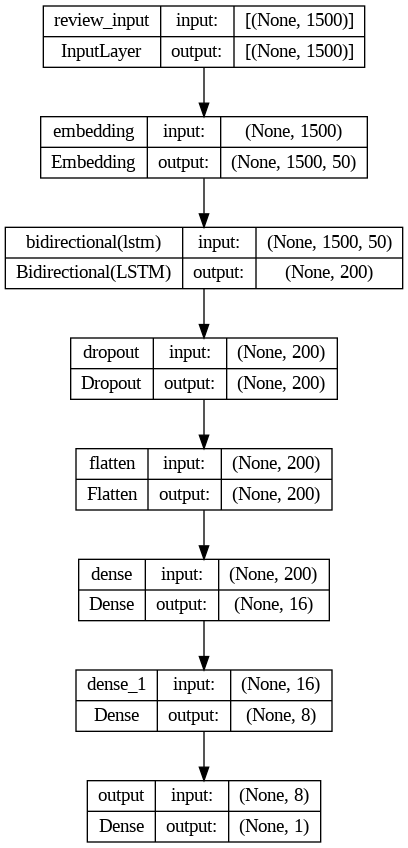

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes = True, show_layer_names = True)


## 6 Train the model

In [ ]:
Y_train = Y_train.astype(float)
Y_train

0         0.0
1         0.0
2         1.0
3         1.0
4         1.0
         ... 
359995    0.0
359996    1.0
359997    0.0
359998    0.0
359999    0.0
Name: label, Length: 360000, dtype: float64

In [ ]:
Y_test = Y_test.astype(float)
Y_test

0        1.0
1        0.0
2        1.0
3        0.0
4        1.0
        ... 
39995    0.0
39996    0.0
39997    1.0
39998    0.0
39999    0.0
Name: label, Length: 40000, dtype: float64

In [ ]:
X_train = X_train.astype(float)
X_train

array([[5.000e+00, 2.585e+03, 1.200e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.300e+02, 2.500e+01, 3.100e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.768e+03, 9.000e+01, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.245e+03, 1.750e+02, 2.810e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+01, 8.760e+02, 4.448e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.500e+01, 4.880e+02, 3.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, Y_train, batch_size=64, epochs=20 , verbose=1, callbacks=[early_stopping], validation_data=(X_test, Y_test))

Epoch 1/20
5625/5625 [==============================] - 570s 100ms/step - loss: 0.3608 - accuracy: 0.8461 - val_loss: 0.3053 - val_accuracy: 0.8717
Epoch 2/20
5625/5625 [==============================] - 565s 101ms/step - loss: 0.3141 - accuracy: 0.8686 - val_loss: 0.3016 - val_accuracy: 0.8739
Epoch 3/20
5625/5625 [==============================] - 564s 100ms/step - loss: 0.2882 - accuracy: 0.8810 - val_loss: 0.3289 - val_accuracy: 0.8592
Epoch 4/20
5625/5625 [==============================] - 563s 100ms/step - loss: 0.2772 - accuracy: 0.8856 - val_loss: 0.2641 - val_accuracy: 0.8907
Epoch 5/20
5625/5625 [==============================] - 565s 100ms/step - loss: 0.2574 - accuracy: 0.8957 - val_loss: 0.2552 - val_accuracy: 0.8947
Epoch 6/20
5625/5625 [==============================] - 565s 100ms/step - loss: 0.2455 - accuracy: 0.9009 - val_loss: 0.2493 - val_accuracy: 0.8983
Epoch 7/20
5625/5625 [==============================] - 565s 100ms/step - loss: 0.2362 - accuracy: 0.9046 - val_

The best accuracy of the model on the train set is about 0.92. This high accuracy means that the model can capture the underlying patterns in the training dataset. However, we need to compare the accuracy, recall, precision, specificity and F1 on test dataset.

## 6.1 Saving the model

In [ ]:
model.save("AmazonReviews_LSTM.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download("AmazonReviews_LSTM.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6.2 Load the model file

In [ ]:
import keras
from tensorflow.python.keras.models import load_model
path = "/content/drive/MyDrive/Colab Notebooks/AmazonReviews_LSTM.h5"
#model = load_model(path)
model = keras.models.load_model(path)

## 7 Predicting Results

In [ ]:
predictions = model.predict(X_test)
predictions = predictions.round().astype('float')
predictions

1250/1250 [==============================] - 41s 32ms/step


array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]])

In [ ]:
Y_test

0        1.0
1        0.0
2        1.0
3        0.0
4        1.0
        ... 
39995    0.0
39996    0.0
39997    1.0
39998    0.0
39999    0.0
Name: label, Length: 40000, dtype: float64

## 7.1 Accuracy of the test set

In [ ]:
from sklearn.metrics import accuracy_score
Acc = accuracy_score(predictions, Y_test)

In [ ]:
print('The accuracy of the model on the test set is: {}'.format(Acc))

The accuracy of the model on the test set is: 0.8775


In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Calculate Recall
recall = recall_score(Y_test, predictions, average='binary') # Use 'binary' for binary classification, adjust as necessary

# Calculate Precision
precision = precision_score(Y_test, predictions, average='binary') # Use 'binary' for binary classification, adjust as necessary

# Calculate F1 Score
f1 = f1_score(Y_test, predictions, average='binary') # Use 'binary' for binary classification, adjust as necessary

print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Recall: 0.8614
Precision: 0.8900599297375491
F1 Score: 0.8754954771826405


In [ ]:
# Specificity (True Negative Rate)
tn, fp, fn, tp = confusion_matrix(actual_labels, predicted_labels).ravel()
specificity = tn / (tn + fp)
print(f"Specificity: {specificity}")

Accuracy is 0.8775 which means the model made the correct predictions for 87.75% of the test dataset.
Recall is 0.8614 which means model can identified about 86.14% of actual postive. Fewer false negative (FN) cases.
Precision is 0.8901 which means model can identified all cases as positve is 89.01%. Fewer false positive (FP).
F1 is 0.8754 which means a good balanced between precision (FP) and recall (FN).
Specificity is 0.8657 which means model can identify true negative (TN) as actual negative is 86.57%.  
Overall, our task is aimed to predict negative reviews in order to improve customer experience. Therefore, the LSTM model can perform reliably across different aspects, not only including recall, precision and F1 score, but also identifying specificity.


## 7.2 Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions, Y_test)

The confusion matrix for the test set is : 


<Axes: >

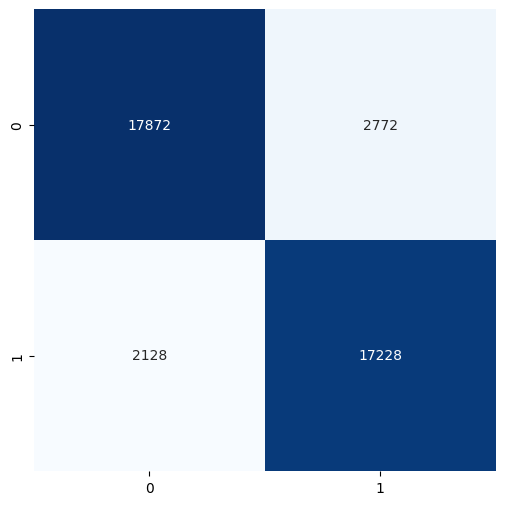

In [ ]:
print('The confusion matrix for the test set is : ')
sns.heatmap(cm, square = True, annot = True, cmap = 'Blues', fmt = 'd', cbar = False)

In [ ]:
predicted_yes = cm[0,1]+cm[1,1]
predicted_no = cm[0,0]+cm[0,1]
print(predicted_yes)
print(predicted_no)

20000
20644


In [ ]:
positive_reviews = cm[1,0]+cm[1,1]
negative_reviews = cm[0,0]+cm[0,1]
print(positive_reviews)
print(negative_reviews)

19356
20644


## 8. Conclusion

1. We have a balanced number of positive and negative reviews
2. We define a text pre-processsing function to cover the reviews into meaningful cleaned reviews.
3. After text pre-processing, we create a model for training and testing purpose.
4. The LSTM model can perform reliably results. Recall: 86.14%. Precision: 89.01%, F1 Score: 87.55%, Precision: 86.57%. Accuracy: 87.75%.

## 9.Reference

1.  Alammar, J. (2023, November 26). A visual guide to using BERT for the first time. Retrieved from https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
2. Kumar, A. (2024). Lecture on natural language processing. [PowerPoint slides]. Goldsmiths, University of London.
3. Stanford NLP. (n.d.). Global Vectors for Word Representation - Twitter [Dataset file: glove.twitter.27B.zip]. Retrieved from https://github.com/stanfordnlp/GloVe
4. Hugging Face. (n.d.). Twitter-roBERTa-base for sentiment analysis. Retrieved from https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
5. Zhang, X. (n.d.). Amazon Reviews for Sentiment Analysis. Kaggle [Dataset]. Retrieved from https://www.kaggle.com/datasets/bittlingmayer/amazonreviews